<a href="https://colab.research.google.com/github/kyle-gao/ML_ipynb/blob/master/TF_ObjectDection_YOLOvsFRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
#@title Imports and function definitions

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

#To draw YOLO output
from IPython.display import Image as IPythonImg
from IPython.display import display

#for YOLO
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import cv2
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs


In [82]:
#@title Helper functions from TF Object detection notebook


def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % sum(result["detection_scores"]>0.3)) #Changed the detection count to a threshold
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

def detect_img(detector,image_url):
  start_time = time.time()
  image_path = download_and_resize_image(image_url, 640, 480)
  run_detector(detector, image_path)
  end_time = time.time()
  print("Inference time:",end_time-start_time)

#Faster R-CNN (region based cnn)
img => conv layers => feature map(conv layer output) =>Region proposal network =>ROIPool + classifier

The region proposal network (RPN) slides a window across the feature map. RPN has a classifier (binary) which gives a probability that the window contains a target object. RPN has a regressor (outputs boxes) which attempts to predict k boxes (parametrized scale/ratio from k anchor boxes) at each location of the window. These are filtered via IoU to ground state anchor boxes.

ROI pool (and more recently ROI align) takes a region of interest (bounding box or list thereof) in the feature map, and acts on it like a Pool layer, mapping the ROI to a specific size.



In [8]:
"""Google's faster_rcnn/openimages_v4/inception_resnet_v2"""
rcnn_hub_url = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

In [9]:
frcnn =   hub.load(rcnn_hub_url).signatures['default'] #~220 MB input_shape = (1,640,480,3) 
#outputs: dict {"detection_boxes":(100,4), "detection_class_entity":(100,),"detection_class_labels":(100,),"detection_class_names":(100,),"detection_scores":(100,)}

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Image downloaded to /tmp/tmpk48k6_79.jpg.
Found 8 objects.
Inference time:  1.3452022075653076
Inference time: 1.517608404159546


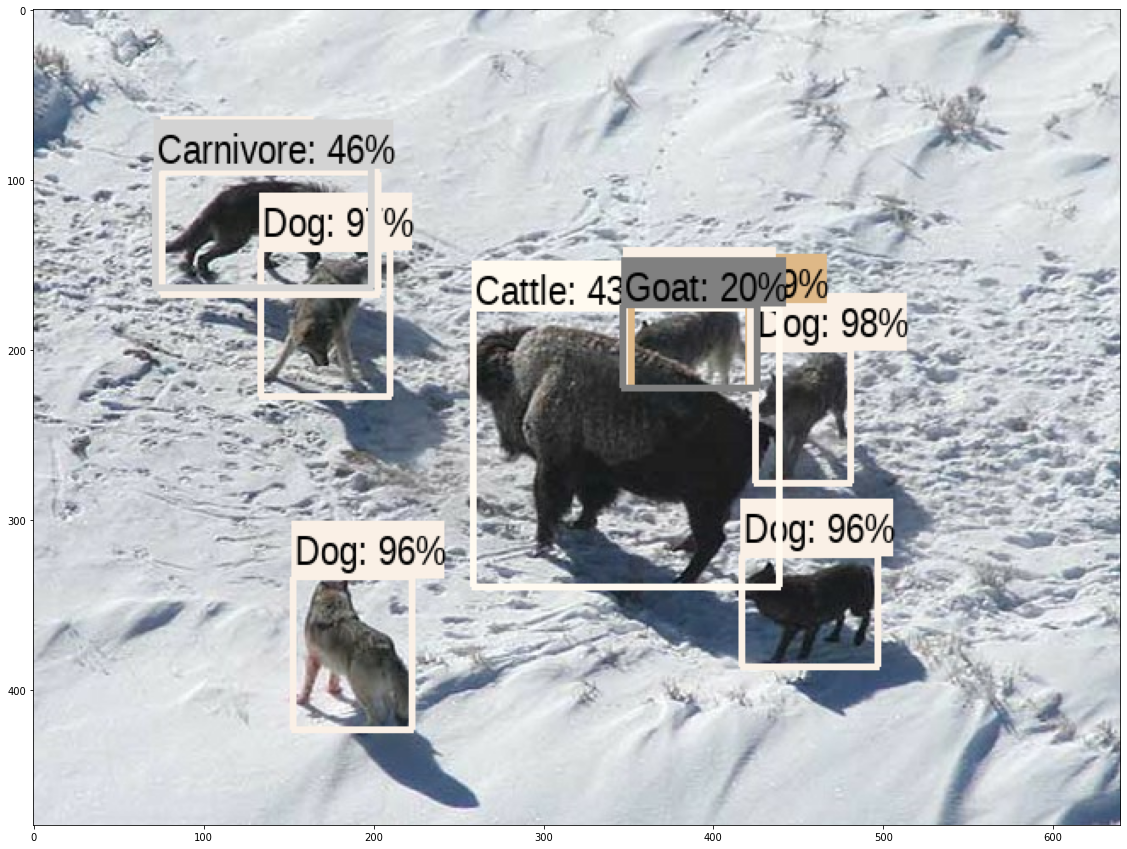

In [83]:
img_url = "https://upload.wikimedia.org/wikipedia/commons/4/45/Canis_lupus_pack_surrounding_Bison.jpg"
detect_img(frcnn,img_url)

#YOLO (you only look once)
img => conv layers => feature map => YOLO detection layer
Divides a feature map into SxS grid of cells, each cell attemps to detect an image within it by predicing a bounding box.

Tries to fit multiple anchor boxes on each cell.

YOLOv3 uses 3 scales and gives 3 bounding box per scale. 

Uses non max suppression and confidence threshold to get rid of overlapping boxes.





In [ ]:
#@title Yolo Algorithm from https://github.com/zzh8829/yolov3-tf2
!git clone https://github.com/zzh8829/yolov3-tf2
%cd yolov3-tf2/
!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights #~230MB
!python convert.py

In [ ]:
flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

In [138]:
def yolo_from_url(img_url):
  image_path = download_and_resize_image(img_url, FLAGS.size, FLAGS.size)

  img_raw = tf.image.decode_image(
    open(image_path, 'rb').read(), channels=3)

  img = tf.expand_dims(img_raw, 0)
  img = transform_images(img, FLAGS.size) # (1,416,416,3)

  t1 = time.time()
  boxes, scores, classes, nums = yolo(img) #4 tuple ( (1,100,4),(1,100),(1,100),() )
  t2 = time.time()
  logging.info('time: {}'.format(t2 - t1))
  print (f"{nums} Detections")


  img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
  img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

  display(IPythonImg(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))

In [139]:
if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)
      
yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

I0925 20:57:59.777159 140452889728896 <ipython-input-139-1973340ba6b4>:7] weights loaded
I0925 20:57:59.780361 140452889728896 <ipython-input-139-1973340ba6b4>:10] classes loaded


I0925 20:58:02.850118 140452889728896 <ipython-input-138-039ff0ca6596>:13] time: 0.09633207321166992


Image downloaded to /tmp/tmp9b8kuwxu.jpg.
[7] Detections


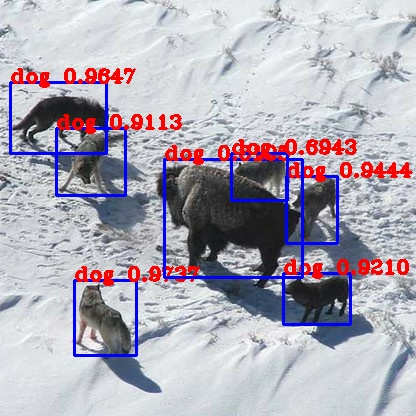

In [140]:
img_url = "https://upload.wikimedia.org/wikipedia/commons/4/45/Canis_lupus_pack_surrounding_Bison.jpg"
yolo_from_url(img_url)

Yolo is almost 20 times faster, however it suffers in performance when detecting small objects. YoloV3 attempts to address that.